# imports, funzioni, pipelines

In [4]:
import sys
import os
#%cd /content/drive/My Drive/Full stack data school/progetto
!pip install transformers -q 
!python -m spacy download en_core_web_lg
!pip install -U spacy -q
!pip install wordcloud -q
!pip install bert-extractive-summarizer -q

/Users/Debora/opt/anaconda3/envs/NPL_PROJECT/bin/python: No module named spacy
  ERROR: Command errored out with exit status 1:
   command: /Users/Debora/opt/anaconda3/envs/NPL_PROJECT/bin/python -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/private/var/folders/hv/hplzffs15b10rh0yk5wmdmkw0000gn/T/pip-install-ppjkz53i/wordcloud/setup.py'"'"'; __file__='"'"'/private/var/folders/hv/hplzffs15b10rh0yk5wmdmkw0000gn/T/pip-install-ppjkz53i/wordcloud/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d /private/var/folders/hv/hplzffs15b10rh0yk5wmdmkw0000gn/T/pip-wheel-_amild_m
       cwd: /private/var/folders/hv/hplzffs15b10rh0yk5wmdmkw0000gn/T/pip-install-ppjkz53i/wordcloud/
  Complete output (24 lines):
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build/lib.macosx-10.9-x86_64-3.6
  creating build/lib.mac

In [5]:
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np

import copy
import torch
import re
import string
import sys
import os

from transformers import BertTokenizer, BertForMaskedLM
from transformers import pipeline
from transformers import AutoTokenizer, AutoModel, AutoModelForQuestionAnswering, AutoModelWithLMHead

from summarizer import Summarizer

import spacy
import en_core_web_lg


ModuleNotFoundError: No module named 'torch'

In [ ]:
def text_lowercase(text):
    return text.lower() 

def remove_punctuation(text): 
    no_punct_text = "".join([char for char in text if char not in string.punctuation])
    return no_punct_text

def remove_whitespace(text): 
    return  " ".join(text.split()) 
    
def keep_letters_digits(text):
  tweet = str(text.lower())  
  tweet = re.sub(r'http\S+', '<website>', tweet)
  tweet = re.sub(r'@\S+', '<tag>', tweet)
  tweet = re.sub(r'[^A-Za-z0-9|#.,!?<>]+', ' ', tweet)
  return tweet

def clean(text) -> str:
  clean = text_lowercase(text)
  clean = remove_punctuation(clean)
  clean = remove_whitespace(clean)
  return keep_letters_digits(clean)

In [ ]:
pos = en_core_web_lg.load()
summ = pipeline('summarization')
# summ = Summarizer()
sa = pipeline("sentiment-analysis") 

/usr/local/lib/python3.6/dist-packages/spacy/util.py:275: UserWarning: [W031] Model 'en_core_web_lg' (2.2.5) requires spaCy v2.2 and is incompatible with the current spaCy version (2.3.2). This may lead to unexpected results or runtime errors. To resolve this, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


# pulizia per nlp, pos, word frequency, wordclouds

In [3]:
df = pd.read_csv('DATA/raw/data_raw_googleplaystore_user_reviews.csv')
df = df.dropna()
df.head()

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000
5,10 Best Foods for You,Best way,Positive,1.00,0.300000


In [ ]:
# funzioni

def make_pos_dict(clean_text) -> dict:
  pos_dict = dict()
  for token in pos(clean_text):
    pos_dict[token.lemma_] = token.pos_  
  return pos_dict

def make_pos_df(clean_text) -> pd.DataFrame:
  lemmas = []
  poss = []
  for token in pos(clean_text):
    lemmas.append(token.lemma_)
    poss.append(token.pos_)
  return pd.DataFrame({'lemma': lemmas, 'part': poss})

def sentiment_analysis(clean_text) -> float:
  sentiment = sa(clean_text)[0]
  label = 1 if sentiment['label'] == 'POSITIVE' else -1
  return round(sentiment['score'] * label, 3)

def join_reviews(column) -> str:
  reviews = column.values
  return ', '.join(reviews)

df['Pos'] = df['Translated_Review'].apply(lambda x: make_pos_dict(clean(x)))

cleaning

In [ ]:
df['Translated_Review'] = df['Translated_Review'].apply(clean)

pos e word frequencies per reviews negative

In [ ]:
negatives = df[df['Sentiment'] == 'Negative']['Translated_Review']
negatives = join_reviews(negatives)
first = negatives[:int(len(negatives)/2)+1]
second = negatives[int(len(negatives)/2)+1:]
first_df = make_pos_df(first)
second_df = make_pos_df(second)
all_neg = pd.concat([first_df, second_df])

negatives = all_neg[(all_neg['part'] == 'ADJ') | (all_neg['part'] == 'NOUN')]

# negatives = all_neg[all_neg['part'] == 'NOUN']
negatives['lemma'].replace({'advertisement': 'ads',
                            'ad': 'ads',
                            'advert': 'ads'}, inplace = True)

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:4581: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [ ]:
# most frequent negative words
negatives['lemma'].value_counts()[:10]

game      4364
time      1759
ads       1271
bad       1104
app        944
level      777
phone      724
update     720
money      549
new        522
Name: lemma, dtype: int64

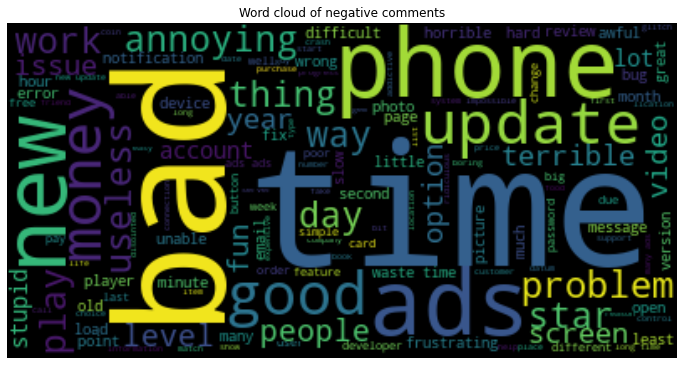

In [ ]:
import wordcloud
from wordcloud import WordCloud

wordcloud = WordCloud().generate(join_reviews(negatives['lemma']).replace(',', '').replace('game', '').replace('app', ''))
plt.figure(figsize = (12,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word cloud of negative comments')
plt.axis("off")
plt.show()

pos e word frequencies per reviews positive

In [ ]:
positives = df[(df['Sentiment'] == 'Positive') | (df['Sentiment'] == 'Neutral') ]['Translated_Review']
positives = join_reviews(positives)
temp = []
for i in range(0, len(positives), 900000):
  batch = positives[i - 900000 : i]
  batch_df = make_pos_df(batch)
  temp.append(batch_df)

positives = pd.DataFrame()
for el in temp:
  positives = pd.concat([positives, el])

# positives = positives[positives['part'] == 'NOUN']
positives = positives[(positives['part'] == 'ADJ') | (positives['part'] == 'NOUN')]
positives['lemma'].replace({'advertisement': 'ads',
                            'ad': 'ads',
                            'advert': 'ads'}, inplace = True)

In [ ]:
# most frequent positive words
positives['lemma'].value_counts()[:20]

good       5566
game       4566
great      3696
app        3540
time       3237
easy       1683
ads        1626
phone      1575
update     1499
thing      1442
many       1406
new        1314
nice       1238
way        1233
free       1229
work       1148
day        1116
problem    1109
fun        1071
star       1038
Name: lemma, dtype: int64

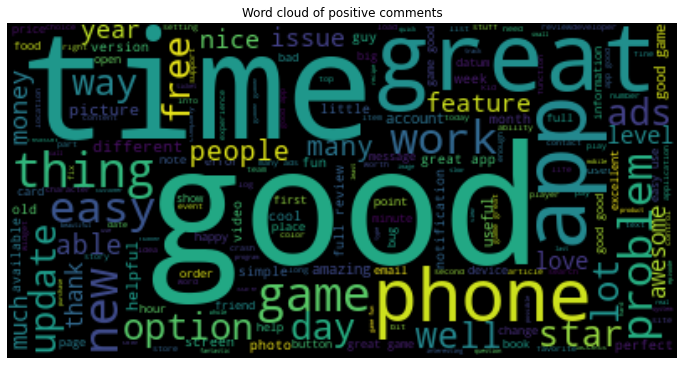

In [ ]:
import wordcloud
from wordcloud import WordCloud

wordcloud = WordCloud().generate(join_reviews(positives['lemma']).replace(',', ''))
plt.figure(figsize = (12,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word cloud of positive comments')
plt.axis("off")
plt.show()

In [ ]:
# da aggiungere: word cloud per categoria, divisa tra postivi e negativi. per la categoria vai in join con l'altro dataset
# da aggiungere: analisi statistica delle parole più significative nelle reviews. In quante reviews è presente la parola ads, problem, easy, screen, ect...

# summarizer 
following cell is experimental (and has failed), please ignore

In [ ]:
# possible summarization, doesn't seem to be useful so far

apps = list(df['App'].value_counts().index)
summ_app = []
summ_label = []
summ_text = []

app = apps[1]

all_app_reviews = df[df['App'] == apps[1]]
app_n = all_app_reviews[all_app_reviews['Sentiment'] == 'Negative']['Translated_Review']
app_p = all_app_reviews[(all_app_reviews['Sentiment'] == 'Positive') | (all_app_reviews['Sentiment'] == 'Neutral')]['Translated_Review'] 
if len(app_n) >= 1:
  joined_n = join_reviews(app_n)
  summ_app.append(app) 
  summ_label.append('Negative')
  # summ_text.append(summ(joined_n))
if len(app_p) >= 1:
  joined_p = join_reviews(app_p)
  summ_app.append(app) 
  summ_label.append('Positive')
  # summ_text.append(summ(joined_p))

t = joined_n.replace('"', '\'')
t = [t]

from transformers import PegasusForConditionalGeneration, PegasusTokenizer
import torch


model_name = 'google/pegasus-xsum'
torch_device = 'cuda' if torch.cuda.is_available() else 'cpu'
tokenizer = PegasusTokenizer.from_pretrained(model_name)
model = PegasusForConditionalGeneration.from_pretrained(model_name).to(torch_device)

batch = tokenizer.prepare_seq2seq_batch(t, truncation=True, padding='longest').to(torch_device)
translated = model.generate(**batch)
tgt_text = tokenizer.batch_decode(translated, skip_special_tokens=True)
print('original NEGATIVE text\n', joined_n)
print('\nsummarized text\n', tgt_text[0])


original NEGATIVE text
 Actually really enjoy playing game, however I paid upgraded version without ads still continued get ads. Emailed developer week ago along attached confirmation purchase never got response, therefore I'm giving star. Just lot downloads mean overlook people support game; especially ones voluntarily pay upgraded version., Love game - really addictive, could added difficulty levels pass by. My kid plays lot too, I thought "let's buy full version help developers". HOWEVER, I paid NO ADDS version, BUT NOTHING CHANGED, adds continue pop usual. Because gets 2 starts :(, I've enjoyed game, giving poor review someone addresses issue. I paid ads removed almost month ago still receiving numerous ads. I've emailed development team Google play store, received response. If nothing changes I'll delete game together leave review permanently, This game opinion simple fun addicting time . However variety colors "trap" positions limited kin getting boring. There also large amount a